In [1]:
%%bash
pip install skflow

Cleaning up...


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gcp
import gcp.bigquery as bq
import skflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [3]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [4]:
%%sql --module use_case_2

DEFINE QUERY trans_by_type
SELECT
  USE_CASE as use_case,
  TRANSACTION_TYPE AS trans_type,
  COUNT(*) AS num_trans
FROM
  [CreditCardv2.cc_trans_02052016]
WHERE
  REGEXP_MATCH(USE_CASE, 'Use Case 2')
  AND CREDIT_DEBIT == 'C'
GROUP BY
  trans_type, use_case
ORDER BY
  trans_type, use_case

In [5]:
trans_by_type = bq.Query(use_case_2.trans_by_type).to_dataframe()

In [6]:
trans_by_type_pivoted = trans_by_type.pivot('trans_type', 'use_case')
trans_by_type_pivoted = trans_by_type_pivoted.fillna(0)
trans_by_type_pivoted

num_trans                   \
use_case                Use Case 2 - Green Use Case 2 - Red   
trans_type                                                    
ACH Payment                      6995617.0        1126334.0   
ACH PaymentCash Payment          2332970.0         376609.0   
ATM Payment                      2332031.0         376759.0   
ATM PaymentPaper Check          13991200.0              0.0   
Cash Payment                     2330893.0         376810.0   
Online Transfer                 16329172.0         375450.0   
Paper Check                      2332869.0         376196.0   
Payment                          5789629.0         353824.0   
Wire Payment                     4665774.0         753237.0   
e-Check Check                   16321869.0         375418.0   

                                             
use_case                Use Case 2 - Yellow  
trans_type                                   
ACH Payment                       1290448.0  
ACH PaymentCash Payment            429694.0  
ATM Payment                        429245.0  
ATM PaymentPaper Check             858162.0  
Cash Payment                       429398.0  
Online Transfer                   1287583.0  
Paper Check                        429013.0  
Payment                            625110.0  
Wire Payment                       859280.0  
e-Check Check                     1291977.0

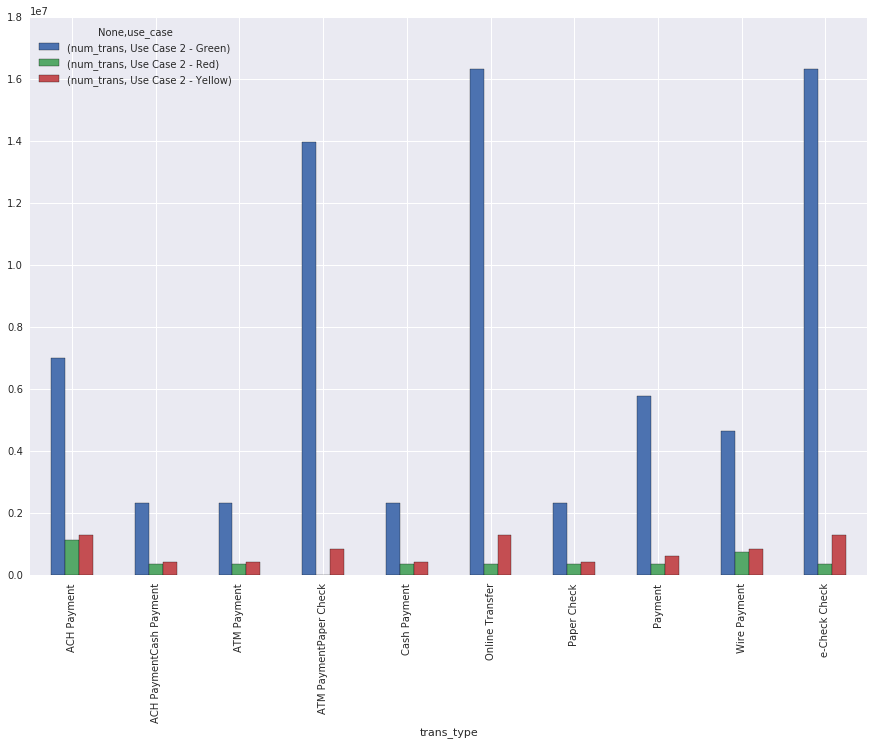

In [7]:
_ = trans_by_type_pivoted.plot(kind='bar', figsize=(15,10))

In [8]:
trans_by_type_pivoted = trans_by_type_pivoted.divide(trans_by_type_pivoted.sum(), axis=1)
trans_by_type_pivoted

num_trans                   \
use_case                Use Case 2 - Green Use Case 2 - Red   
trans_type                                                    
ACH Payment                       0.095280         0.250818   
ACH PaymentCash Payment           0.031775         0.083865   
ATM Payment                       0.031762         0.083899   
ATM PaymentPaper Check            0.190559         0.000000   
Cash Payment                      0.031747         0.083910   
Online Transfer                   0.222402         0.083607   
Paper Check                       0.031773         0.083773   
Payment                           0.078854         0.078791   
Wire Payment                      0.063547         0.167735   
e-Check Check                     0.222302         0.083600   

                                             
use_case                Use Case 2 - Yellow  
trans_type                                   
ACH Payment                        0.162732  
ACH PaymentCash Payment            0.054186  
ATM Payment                        0.054130  
ATM PaymentPaper Check             0.108218  
Cash Payment                       0.054149  
Online Transfer                    0.162370  
Paper Check                        0.054101  
Payment                            0.078829  
Wire Payment                       0.108359  
e-Check Check                      0.162925

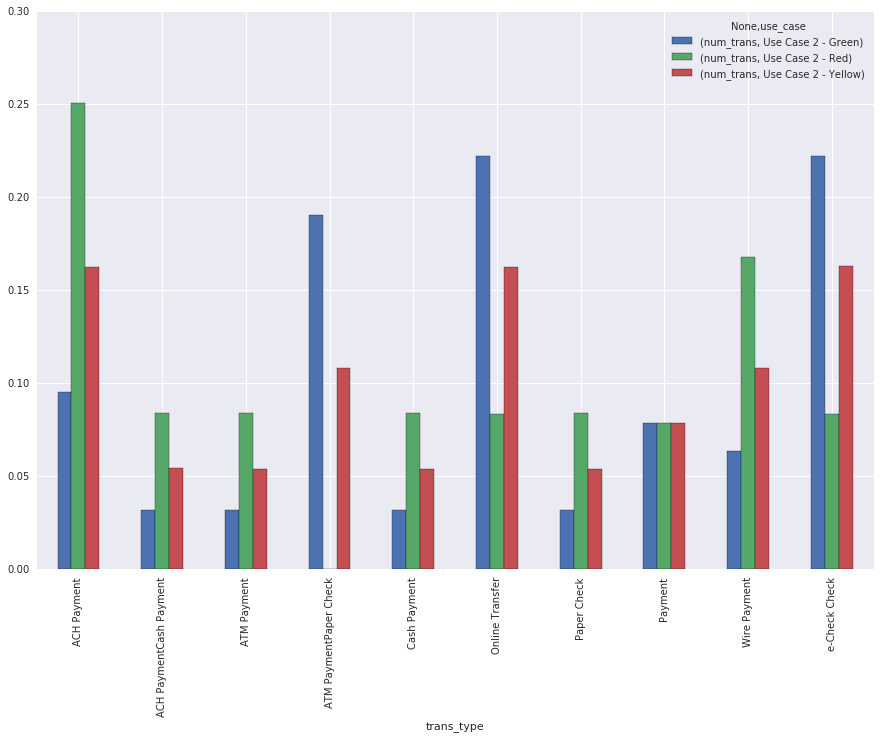

In [9]:
_ = trans_by_type_pivoted.plot(kind='bar', figsize=(15,10))

In [10]:
%%sql --module use_case_2

DEFINE QUERY sample_trans
SELECT
  *
FROM
  [CreditCardv2.cc_trans_02052016]
WHERE
  USE_CASE = $use_case AND
  CREDIT_DEBIT = 'C'
ORDER BY
  ACCOUNTID, TRANSACTION_DATE
LIMIT
  $sample_size

In [11]:
SAMPLE_SIZE = 1000000

GREEN_USE_CASE = 'Use Case 2 - Green'
YELLOW_USE_CASE = 'Use Case 2 - Yellow'
RED_USE_CASE = 'Use Case 2 - Red'

GREEN = 'Green'
YELLOW = 'Yellow'
RED = 'Red'

In [12]:
# This function transforms our DataFrame from a row per transaction to a column per credit event type.
# This introduces some NaN elements so it also transforms those to 'Missing'
# TRANSACTION_DATE is included to allow us to later combine and sort different samples together.

def widen_trans_per_account(sample_trans, use_case, width):
  
  sample_trans_acct_ids = sample_trans.ACCOUNTID.drop_duplicates()

  sample_trans_wide = pd.DataFrame()

  for sample_trans_acct_id in sample_trans_acct_ids:
    sample_trans_acct = sample_trans[sample_trans.ACCOUNTID == sample_trans_acct_id]
    tmp = pd.DataFrame()
    for i in range(width):
      tmp['shift_' + str(i)] = sample_trans_acct.TRANSACTION_TYPE.shift(i)
    sample_trans_wide = pd.concat([sample_trans_wide, tmp])

  sample_trans_wide['USE_CASE'] = use_case
  sample_trans_wide['TRANSACTION_DATE'] = sample_trans.TRANSACTION_DATE
  
  sample_trans_wide = sample_trans_wide.fillna('Missing')
  
  return sample_trans_wide

In [13]:
sample_trans_green = bq.Query(use_case_2.sample_trans, use_case = GREEN_USE_CASE, sample_size=SAMPLE_SIZE).to_dataframe()
sample_trans_green[:3]

,ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0,2_2016-02-04 17:45:21,100000039,None,1111,Customer Payment,US,2015-01-06,2015-01-05,e-Check Check,C,20000,101,262,18442345145083904,amex,Use Case 2 - Green,Zilpha Trantow DDS,3,RESEDA,CA,91335,US,None
1,4_2016-02-04 17:45:21,100000039,None,1111,Customer Payment,US,2015-01-10,2015-01-09,e-Check Check,C,20000,1,16,18442345145083904,amex,Use Case 2 - Green,Zilpha Trantow DDS,3,RESEDA,CA,91335,US,None
2,7_2016-02-04 17:45:21,100000039,None,1111,Customer Payment,US,2015-01-16,2015-01-15,e-Check Check,C,20000,1,5,18442345145083904,amex,Use Case 2 - Green,Zilpha Trantow DDS,3,RESEDA,CA,91335,US,None


In [ ]:
sample_trans_yellow = bq.Query(use_case_2.sample_trans, use_case = YELLOW_USE_CASE, sample_size=SAMPLE_SIZE).to_dataframe()
sample_trans_yellow[:3]